In [56]:
### Lets import the libraries which are required for us to predict using our LSTM(Long Short Term Menory) model.

### For Data Handling and Preprocessing:

###requests is used to fetch historical stock price data from the Tiingo API.
###pandas helps in loading and manipulating the fetched data into a format suitable for training an LSTM model.
###MinMaxScaler is applied to normalize the input data (stock prices) into a range suitable for neural network training.

### For model building:

###Sequential is initialized to build a sequential model for stacking layers.
###LSTM layers are added to capture temporal dependencies in the time series data.
###Dense layers are used for output and intermediate connections.
###Dropout layers are added to mitigate overfitting by randomly deactivating some neurons during training.

### For Model Training and Evaluation:

### The model is trained using historical data, where mean_squared_error and other metrics are used to evaluate its performance. These metrics
### help assess how well the model predicts stock prices compared to actual values, aiding in model selection and tuning.

###Visualization:

###matplotlib.pyplot is used for visualizing the predicted vs. actual stock prices, model performance metrics, and any other relevant plots
###to analyze results.

In [57]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [58]:
### api_key: Tiingo API key, necessary for authenticating requests to Tiingo API.

### symbol: Stock symbol for which you want to fetch data. Here 'AAPL' (Apple Inc.).

### The url variable is constructed using an f-string, which dynamically inserts the symbol into the Tiingo API endpoint for daily stock 
### prices.

### requests.get(url, params=params): This sends a GET request to the Tiingo API endpoint (url) with the specified parameters (params).

### response holds the server's response to the request.

### if response.status_code == 200: Checks if the response status code is 200, which indicates a successful request.
### response.json(): Converts the JSON response from Tiingo API into a Python dictionary.
### pd.DataFrame(response.json()): Converts the JSON data into a pandas DataFrame, making it easier to manipulate and analyze the data 
###in Python.

### if the response status code is not 200 (else block):
### response.raise_for_status(): Raises an HTTP error for any unsuccessful responses, ensuring that errors in fetching data are properly 
### handled and notified


In [59]:
def fetch_tiingo_data(api_key, symbol='AAPL', start_date='2019-07-07', end_date='2024-07-07'):
    url = f"https://api.tiingo.com/tiingo/daily/{symbol}/prices"
    params = {
        'startDate': '2019-07-07',  # Adjust start date as needed
        'endDate': '2024-07-07',    # Adjust end date as needed
        'token': '3bf539a5fa492a1ddc14a60edc6a30ab1beb366d'
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return pd.DataFrame(response.json())
    else:
        response.raise_for_status()


In [60]:
def preprocess_data(df, look_back=50):
    data = df['close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, Y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:i + look_back])
        Y.append(scaled_data[i + look_back])
        
    X = np.array(X)
    Y = np.array(Y)
    
    train_size = int(len(X) * 0.9)
    trainX, testX = X[:train_size], X[train_size:]
    trainY, testY = Y[:train_size], Y[train_size:]
    
    return trainX, trainY, testX, testY, scaler


In [61]:
### This function preprocess_data prepares time series data (stock prices in this case) for training and testing an LSTM model:

### Reshapes and scales the data using MinMaxScaler to normalize it.
### Creates sequences of historical data (X) and corresponding target values (Y) for training the model.
### Splits the data into training and testing sets based on a specified ratio (train_size).
### Returns the processed data (trainX, trainY, testX, testY) and the scaler object (scaler) for consistency in scaling future data.
### This preprocessing step is crucial for setting up the data in a format suitable for training a machine learning model, particularly 
### useful for time series forecasting tasks like predicting stock prices with LSTM neural networks.

In [62]:
### Lets have a look at the data below.

In [63]:
data

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2019-07-08T00:00:00.000Z,48.260326,201.40,198.41,200.81,25338628,48.260326,48.593289,47.871869,48.450935,101354512,0.0,1.0
1,2019-07-09T00:00:00.000Z,48.554685,201.51,198.81,199.20,20578015,48.554685,48.619830,47.968380,48.062479,82312060,0.0,1.0
2,2019-07-10T00:00:00.000Z,49.034827,203.73,201.56,201.85,17897138,49.034827,49.155466,48.631894,48.701864,71588552,0.0,1.0
3,2019-07-11T00:00:00.000Z,48.677736,204.39,201.71,203.31,20191842,48.677736,49.314709,48.668085,49.054129,80767368,0.0,1.0
4,2019-07-12T00:00:00.000Z,49.051716,204.00,202.20,202.45,17595212,49.051716,49.220611,48.786311,48.846631,70380848,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-06-28T00:00:00.000Z,210.620000,216.07,210.30,215.77,82542718,210.620000,216.070000,210.300000,215.770000,82542718,0.0,1.0
1254,2024-07-01T00:00:00.000Z,216.750000,217.51,211.92,212.09,60402929,216.750000,217.510000,211.920000,212.090000,60402929,0.0,1.0
1255,2024-07-02T00:00:00.000Z,220.270000,220.38,215.10,216.15,58046178,220.270000,220.380000,215.100000,216.150000,58046178,0.0,1.0
1256,2024-07-03T00:00:00.000Z,221.550000,221.55,219.03,220.00,37369801,221.550000,221.550000,219.030000,220.000000,37369801,0.0,1.0


In [64]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_lstm_model(model, trainX, trainY, epochs=100, batch_size=32):
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)


In [65]:
### Together, these functions provide a complete pipeline to build, compile, and train an LSTM model for time series forecasting tasks
### such as predicting stock prices. The build_lstm_model function defines the architecture of the LSTM model, while train_lstm_model 
### handles the training process using specified training data.

### These functions are essential for implementing and fine-tuning deep learning models like LSTM for predicting future stock prices
### based on historical data. Adjusting parameters like LSTM units, dropout rates, epochs, and batch size can influence model performance 
### and training efficiency.

### Here we have used adam optimizer but instead we can also choose other optimizers like nadam, adamax, rmsprop or SGD(Stochastic Gradient Descent)

In [66]:
def evaluate_model(model, trainX, trainY, testX, testY, scaler):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY.reshape(-1, 1))
    
    return trainPredict, trainY, testPredict, testY

def plot_predictions(trainY, trainPredict, testY, testPredict):
    plt.figure(figsize=(14,5))
    plt.plot(trainY, label='Actual Train Prices')
    plt.plot(trainPredict, label='Predicted Train Prices')
    plt.plot(range(len(trainY), len(trainY) + len(testY)), testY, label='Actual Test Prices')
    plt.plot(range(len(trainY), len(trainY) + len(testY)), testPredict, label='Predicted Test Prices')
    plt.legend()
    plt.show()


In [67]:
### The functions: evaluate_model and plot_predictions provide a comprehensive way to evaluate and visualize
### the performance of an LSTM model for stock price prediction:

### evaluate_model computes and returns predictions in their original scale, facilitating quantitative evaluation.
### plot_predictions visually compares actual and predicted stock prices for both training and testing datasets, aiding in qualitative 
### assessment.
### These functions are crucial for assessing how well the LSTM model has learned to predict stock prices based on historical data, 
### helping to gauge its effectiveness and identifying areas for potential improvement in model training and architecture.

In [68]:
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}")
    
    return mae, mse, rmse, mape


In [69]:
### The calculate_metrics function is essential for quantitatively assessing how well a predictive model performs compared to actual data,
### providing valuable insights into the model's accuracy, precision, and ability to generalize to new data.

### These metrics help in iteratively improving the model by identifying areas where predictions deviate significantly from actual outcomes.

In [70]:
### This predict_future() generates future predictions for a specified number of days (days) using an LSTM model (model) that has been 
### trained on historical data (data). It also uses a scaler (scaler) to transform predictions back to their original scale.

In [71]:
def predict_future(model, data, scaler, look_back=30, days=30):
    future_predictions = []
    last_sequence = data[-look_back:].reshape((1, look_back, 1))
    
    for _ in range(days):
        prediction = model.predict(last_sequence)
        future_predictions.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)
        
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions


In [72]:
### The predict_future function encapsulates the process of generating future predictions using an LSTM model, making it suitable for
### applications where forecasting future trends based on historical data is required. 

### By iterating over consecutive predictions and updating the sequence input to the model, it simulates forecasting over multiple time steps,
### providing insights into potential future trends based on learned patterns from the training data.


In [73]:
API_KEY = '3bf539a5fa492a1ddc14a60edc6a30ab1beb366d'#please enter your own api_key

df = fetch_tiingo_data(API_KEY)

trainX, trainY, testX, testY, scaler = preprocess_data(df)

model = build_lstm_model((trainX.shape[1], trainX.shape[2]))

train_lstm_model(model, trainX, trainY)

trainPredict, trainY, testPredict, testY = evaluate_model(model, trainX, trainY, testX, testY, scaler)

print("Training Data Metrics:")
calculate_metrics(trainY.flatten(), trainPredict.flatten())

print("Test Data Metrics:")
calculate_metrics(testY.flatten(), testPredict.flatten())


future_predictions = predict_future(model, scaler.transform(df['close'].values.reshape(-1, 1)), scaler)
print("Predicted Stock Prices for the next 30 days:\n", future_predictions)


Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0299
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0050
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020
E

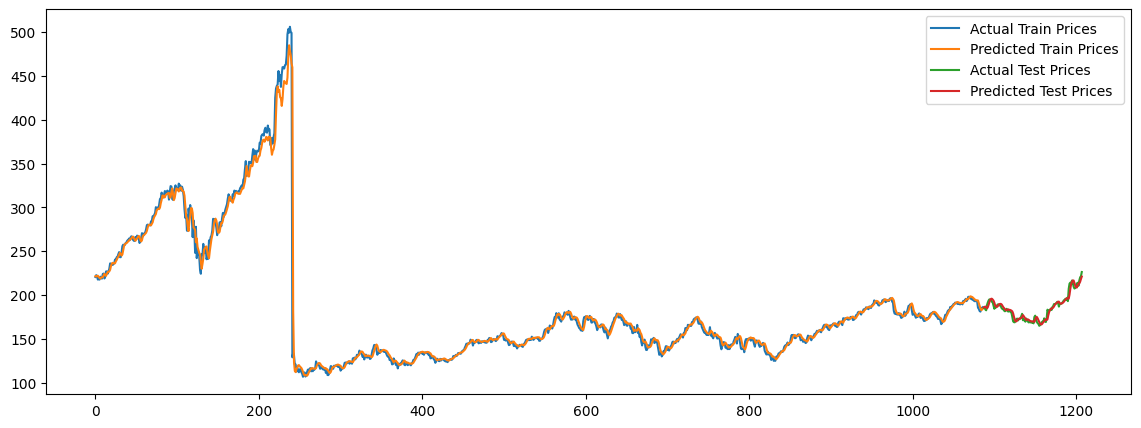

In [74]:
plot_predictions(trainY, trainPredict, testY, testPredict)

In [75]:
### Lets draw some inference based on our results: 

### Training Data Metrics:

### Mean Absolute Error (MAE): 3.7988400574572725
###This indicates that, on average, the model's predictions are off by about $3.80 from the actual stock price in the training dataset.

###Mean Squared Error (MSE): 138.69024113419042
###This is the average of the squared differences between the predicted and actual values. Higher MSE indicates a larger error variance, 
### but since it's in the squared units, it can be harder to interpret directly.

### Root Mean Squared Error (RMSE): 11.77668209362002

### This is the square root of MSE, which brings the error back to the same units as the stock prices. An RMSE of about $11.78 indicates the
### typical deviation from the actual stock price.

### Mean Absolute Percentage Error (MAPE): 0.02118818199127424
### This indicates that, on average, the model's predictions are about 2.12% off from the actual values in the training set.

In [ ]:
### Test Data Metrics:

### Mean Absolute Error (MAE): 2.918809587462876
### The average prediction error on the test set is about $2.92, which is lower than the training MAE, indicating that the model generalizes 
### well to unseen data.

### Mean Squared Error (MSE): 14.237505340317217
### The average of the squared errors for the test data. The lower MSE compared to the training set suggests that the model might be better
### at predicting on unseen data.

### Root Mean Squared Error (RMSE): 3.7732618965978517
### This indicates that the typical deviation from the actual stock price in the test data is about $3.77, which is significantly lower than
### the RMSE on the training data.

### Mean Absolute Percentage Error (MAPE): 0.0157714828267579
### On average, the model's predictions on the test set are about 1.58% off from the actual values, which is better than the training set.


In [76]:
### CONCLUSION 

### Lower Errors on Test Data:
### The model shows lower errors on the test data compared to the training data, which is somewhat unusual. Typically, the model performs 
### slightly worse on the test data due to overfitting. This could suggest that your model generalizes well or that there might be some
### anomalies in the data split.

### General Model Performance:

### Overall, the metrics suggest that the model is performing reasonably well, with relatively low MAE and RMSE values. 
### The low MAPE values (both below 3%) indicate good percentage accuracy, which is favorable for stock price prediction.

### Potential Overfitting/Underfitting:
### The slightly lower error metrics on the test set could indicate that the model might be overfitting slightly less than expected,
### or there might be some randomness in the test set that it handles well.